In [1]:
import warnings
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import os
from sklearn.model_selection import train_test_split
from helpers.pdf_utils import _repr_latex_, head

if "KNIT_PDF" in os.environ:
    warnings.simplefilter(action="ignore", category=FutureWarning)

    pd.DataFrame._repr_latex_ = _repr_latex_
    pd.Series._repr_latex_ = _repr_latex_
    pd.DataFrame.head = head
    pd.Series.head = head
    pd.set_option(
        "max_colwidth",
        30,
        "display.latex.repr",
        True,
    )

# Exploratory Data Analysis

Before we start building our model, let's take a look at the data we have. We'll start by loading the data into a pandas dataframe. After that, we'll take a look at the data, and preprocess it to make it ready for the feature engineering / feature extraction step.
Evntually, we'll split the data for train, validation and test sets, and look for interesting patterns in the train data that our model can learn from.

In [2]:
nutrients = pd.read_csv("data/nutrients.csv")
food_nutrients = pd.read_csv("data/food_nutrients.csv")
food_train = pd.read_csv("data/food_train.csv")


\

## Food Nutrients Dataset

In [3]:
display(food_nutrients.shape)
food_nutrients.head()

(493054, 3)

,idx,nutrient_id,amount
0,1,1087,143.00
1,1,1089,5.14
2,1,1104,0.00
3,1,1162,0.00
4,1,1003,7.14


The amount column isn't meaningful without the serving units. This gives us a hint that we need to merge information from the two datasets.

There're no missing values within the nutrients dataset:

In [4]:
food_nutrients.isna().any().any()

False

There are only 48 unique nutrients in the snacks dataset:

In [5]:
food_nutrients["nutrient_id"].nunique()

48

It would be convenient to add a column for each nutrient and fill it with the amount of the nutrient in the food. Default value will be 0, indicating the food doesn't contain the nutrient. This way, we can easily join the food_nutrients with the snacks datasets.

In [6]:
food_nutrients_wide = food_nutrients.pivot_table(
    index=["idx"], columns=["nutrient_id"], values=["amount"], fill_value=0
).droplevel(0, axis=1)
food_nutrients_wide.head()  # single row for each snack

nutrient_id,1003,1004,1005,1008,1009,1018,1056,1062,1072,1078,...,1178,1185,1186,1235,1253,1257,1258,1292,1293,2000
idx,,,,,,,,,,,,,,,,,,,,,
1,7.14,35.71,53.57,536,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,18,0.0,25.00,0.0,0.0,42.86
2,2.63,15.79,68.42,421,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,26,0.0,6.58,0.0,0.0,42.11
3,3.33,15.00,70.00,433,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,17,0.0,6.67,0.0,0.0,43.33
4,5.00,22.50,67.50,475,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,0,0.0,17.50,0.0,0.0,47.50
5,7.50,42.50,47.50,600,0.0,0,0,0,0,0,...,0.0,0.0,0,0.0,12,0.0,17.50,0.0,0.0,40.00


In [7]:
(food_nutrients_wide > 0).mean().sort_values().head(10)

nutrient_id
1018    0.000000
1009    0.000028
1062    0.000028
1102    0.000057
1176    0.000057
1078    0.000057
1109    0.000340
1056    0.000397
1186    0.000595
1072    0.000652
dtype: float64

Some nutrients are very rare. Still, we'll keep them in the dataset for now, and see if they're useful for our model. It might be due to the fact that some nutrients are only found in a specific food category.

We aim to use the nutrients dataset to predict the food category, as there aren't too many nutrient variables. Therefore, we need to merge the nutrients dataset with the snacks dataset. We'll use the food id to merge the two datasets.

\


## Nutrients Dataset

In [8]:
display(nutrients.shape)
nutrients.head()

(235, 3)

,nutrient_id,name,unit_name
0,1002,Nitrogen,G
1,1003,Protein,G
2,1004,Total lipid (fat),G
3,1005,"Carbohydrate, by difference",G
4,1007,Ash,G


No missing values in nutrients:

In [9]:
nutrients.isna().any().any()

False

A single duplicated name:

In [10]:
nutrients[nutrients["name"].duplicated(keep=False)].sort_values(by="name")

,nutrient_id,name,unit_name
5,1008,Energy,KCAL
23,1062,Energy,kJ


It might be useful to later unify there 2 nutrients into 1, as they are the same. We'll do that by scaling by the appropriate factor (KCAL -> KJ).

Before applying any machine learning algorithms, we usually need to preprocess the data. This includes feature scaling as well. Thus, `unit_name` variable is redundant, as it's just a string representation a scaling factor. We'll add the unit name as a suffix to the column name, and then drop the `unit_name` column.

In [11]:
nutrients_v2 = nutrients.copy()

nutrients_v2.loc[:, "name"] = (
    nutrients.apply(lambda row: f'{row["name"]}__({row["unit_name"]})', axis=1)
    .str.replace(" ", "_")
    .str.replace(",", "")
    .str.lower()
)
nutrients_v2.drop(columns=["unit_name"], inplace=True)
nutrients_v2.set_index("nutrient_id", inplace=True)

nutrients_v2.head()

,name
nutrient_id,
1002,nitrogen__(g)
1003,protein__(g)
1004,total_lipid_(fat)__(g)
1005,carbohydrate_by_difference__(g)
1007,ash__(g)


Now let's merge the information both two datasets, keeping in mind that we need to scale the `KCAL` nutrient by 4.184 to get `KJ`.

In [12]:
food_nutrients_merged = food_nutrients_wide.rename(mapper=nutrients_v2["name"], axis=1)

food_nutrients_merged.loc[:, "energy__(kj)"] += (
    4.184 * food_nutrients_merged.loc[:, "energy__(kcal)"]
)  # convert kcal to kJ
food_nutrients_merged.drop(
    columns=["energy__(kcal)"], inplace=True
)  # duplicated nutrient

food_nutrients_merged.head()

nutrient_id,protein__(g),total_lipid_(fat)__(g),carbohydrate_by_difference__(g),starch__(g),alcohol_ethyl__(g),sorbitol__(g),energy__(kj),carbohydrate_other__(g),xylitol__(g),fiber_total_dietary__(g),...,vitamin_b-12__(ug),vitamin_k_(phylloquinone)__(ug),folic_acid__(ug),sugars_added__(g),cholesterol__(mg),fatty_acids_total_trans__(g),fatty_acids_total_saturated__(g),fatty_acids_total_monounsaturated__(g),fatty_acids_total_polyunsaturated__(g),sugars_total_including_nlea__(g)
idx,,,,,,,,,,,,,,,,,,,,,
1,7.14,35.71,53.57,0.0,0,0,2242.624,0,0,3.6,...,0.0,0.0,0,0.0,18,0.0,25.00,0.0,0.0,42.86
2,2.63,15.79,68.42,0.0,0,0,1761.464,0,0,0.0,...,0.0,0.0,0,0.0,26,0.0,6.58,0.0,0.0,42.11
3,3.33,15.00,70.00,0.0,0,0,1811.672,0,0,0.0,...,0.0,0.0,0,0.0,17,0.0,6.67,0.0,0.0,43.33
4,5.00,22.50,67.50,0.0,0,0,1987.400,0,0,2.5,...,0.0,0.0,0,0.0,0,0.0,17.50,0.0,0.0,47.50
5,7.50,42.50,47.50,0.0,0,0,2510.400,0,0,5.0,...,0.0,0.0,0,0.0,12,0.0,17.50,0.0,0.0,40.00


It might be plausible to later drop infrequent nutrients, as they might not be useful for the classification task. Let's check the most infrequent nutrients:

In [13]:
(food_nutrients_merged > 0).sum().sort_values().to_frame().rename(
    columns={0: "frequency"}
).head()

,frequency
nutrient_id,
alcohol_ethyl__(g),0
starch__(g),1
molybdenum_mo__(ug),2
biotin__(ug),2
xylitol__(g),2


All the information we need is now in a single dataframe. Recall that each nutrient column is associates with a single unit name. We tried to find a correlation between the category and the sum of nutrients values, grouped by the unit name, but decided to drop it.
We can now start exploring the data, and see if we can find any interesting patterns.

In [14]:
food_nutrients_merged.to_csv("data/food_nutrients_merged.csv")


\


## Food Training Dataset

### Hold-Out

We'll split to train, validation and test sets before we start to explore the data, so we won't have to worry about data leakage. We'll use 15% of the data for validation and 5% for test.

In [15]:
features_df = food_train.drop("category", axis=1)
labels_df = food_train["category"]

X_train, X_val_test, y_train, y_val_test = train_test_split(
    features_df, labels_df, test_size=0.2, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test, test_size=0.25, random_state=42
)

X_train["y"] = y_train


\


### Missing Values

In [16]:
X_train.isna().sum().to_frame()

,0
idx,0
brand,0
description,0
ingredients,30
serving_size,0
serving_size_unit,0
household_serving_fulltext,10
y,0


Let's check the columns with missing values. The household_serving_fulltext didn't have many missing values, and I couldn't find any useful information about it, so I decided to skip it.

In [17]:
X_train[X_train["ingredients"].isna()].head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,y
28035,31154,signature snacks,enrobed wafers,NaN,30.0,g,1 wafer,candy
9291,10337,mariani nut co.inc.,"mariani nut company, blanched slivered almonds",NaN,30.0,g,0.25 cup,popcorn_peanuts_seeds_related_snacks
3393,3785,the kroger co.,raw unsalted almonds,NaN,30.0,g,0.25 cup,popcorn_peanuts_seeds_related_snacks
13912,15450,super store industries,"sunny select, dry roasted sunflower seeds",NaN,28.0,g,1 onz,popcorn_peanuts_seeds_related_snacks
19279,21379,"goya foods, inc.",yellow popcorn,NaN,47.0,g,0.25 cup,popcorn_peanuts_seeds_related_snacks


In [18]:
X_train[X_train["ingredients"].isna()]["y"].value_counts(
    normalize=True
).to_frame().rename(columns={"y": "rate"})

,rate
popcorn_peanuts_seeds_related_snacks,0.600000
cakes_cupcakes_snack_cakes,0.166667
candy,0.100000
cookies_biscuits,0.066667
chips_pretzels_snacks,0.033333
chocolate,0.033333


Seems like there's a majority of `ingredients` missing values for the `popcorn_peanuts_seeds_related_snacks` category. That being said, there's less than 1% of the data missing, and I couldn't find intersting significant patterns about the snacks with missing ingredients. Thus, we'll replace the missing values with the string "na", and leave it as is.

In [19]:
from helpers.preprocess import FillNA

FillNA().fit_transform(X=X_train)

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,y
23212,25784,"ahold usa, inc.",fudge brownie bites,"sugar, bleached wheat flour, soybean oil, wate...",28.0,g,1 onz,cakes_cupcakes_snack_cakes
22158,24607,casa cardenas,vanilla cream wafers,"filling (sugar, vegetable shortening (may cont...",30.0,g,4 pieces,cookies_biscuits
1703,1898,"meijer, inc.","markets of meijer, plain cake donut holes","enriched wheat flour (flour, niacin, reduced i...",54.0,g,4 holes,cakes_cupcakes_snack_cakes
20886,23191,"mccormick & company, inc.","kitkat, crisp wafers in milk chocolate",sugar; wheat flour; nonfat milk; cocoa butter;...,42.0,g,1 four-piece bar,candy
18703,20739,tasty baking company,"tastykake, sponge cakes krimpets, orange cream...","sugar, enriched bleached flour (wheat flour, n...",67.0,g,2 cakes/1 pkg,cakes_cupcakes_snack_cakes
...,...,...,...,...,...,...,...,...
29802,33105,first street,chocolate fudge brownies,"sugar, enriched wheat flour bleached (flour, n...",85.0,g,3 onz,cakes_cupcakes_snack_cakes
5390,6019,smart & final iris corporation,"first street, patriotic frosted sugar sugar co...","sugar, enriched bleached wheat flour (flour, n...",38.0,g,1 cookie,cookies_biscuits
860,960,el ranchero food products,"el romchero, tortilla chips","corn, line and corn oil.",39.0,g,1.4 onz,chips_pretzels_snacks
15795,17524,"nuts about granola, llc",granola,"sunflower seeds, almonds, date sugar (dates), ...",28.0,g,0.25 cup,cookies_biscuits


Now, we'll join the snacks dataset with the `food_nutrients_merged` dataset. We'll use the `food_id` column to join the two datasets.

In [20]:
from helpers.preprocess import MergeWithFoodNutrients

X_train = MergeWithFoodNutrients().fit_transform(X=X_train)
X_train.shape

(25400, 55)

We have a dataset of 55 features, combining information from all 3 tabular datasets:

In [21]:
X_train.head()

,idx,brand,description,ingredients,serving_size,serving_size_unit,household_serving_fulltext,y,protein__(g),total_lipid_(fat)__(g),...,vitamin_b-12__(ug),vitamin_k_(phylloquinone)__(ug),folic_acid__(ug),sugars_added__(g),cholesterol__(mg),fatty_acids_total_trans__(g),fatty_acids_total_saturated__(g),fatty_acids_total_monounsaturated__(g),fatty_acids_total_polyunsaturated__(g),sugars_total_including_nlea__(g)
23212,25784,"ahold usa, inc.",fudge brownie bites,"sugar, bleached wheat flour, soybean oil, wate...",28.0,g,1 onz,cakes_cupcakes_snack_cakes,3.57,21.43,...,0.0,0.0,0,0.0,0,0.0,3.57,8.93,8.93,39.29
22158,24607,casa cardenas,vanilla cream wafers,"filling (sugar, vegetable shortening (may cont...",30.0,g,4 pieces,cookies_biscuits,3.33,30.00,...,0.0,0.0,0,0.0,0,0.0,15.00,0.00,0.00,36.67
1703,1898,"meijer, inc.","markets of meijer, plain cake donut holes","enriched wheat flour (flour, niacin, reduced i...",54.0,g,4 holes,cakes_cupcakes_snack_cakes,5.56,22.22,...,0.0,0.0,0,0.0,37,0.0,8.33,0.00,0.00,14.81
20886,23191,"mccormick & company, inc.","kitkat, crisp wafers in milk chocolate",sugar; wheat flour; nonfat milk; cocoa butter;...,42.0,g,1 four-piece bar,candy,7.14,26.19,...,0.0,0.0,0,0.0,12,0.0,16.67,0.00,0.00,50.00
18703,20739,tasty baking company,"tastykake, sponge cakes krimpets, orange cream...","sugar, enriched bleached flour (wheat flour, n...",67.0,g,2 cakes/1 pkg,cakes_cupcakes_snack_cakes,2.99,13.43,...,0.0,0.0,0,0.0,75,0.0,4.48,3.73,3.73,44.78


Let's analyze the data a bit more.

\


### Ingredients

The `ingredients` is an interesting column, as it may be considered as a nested column. Some of the ingredients contains list of ingredients, and some contains a single ingredient. We'll need to preprocess this column before we can use it for training.

In [22]:
X_train["ingredients"].head()

23212    sugar, bleached wheat flour, soybean oil, wate...
22158    filling (sugar, vegetable shortening (may cont...
1703     enriched wheat flour (flour, niacin, reduced i...
20886    sugar; wheat flour; nonfat milk; cocoa butter;...
18703    sugar, enriched bleached flour (wheat flour, n...
Name: ingredients, dtype: object

Note that the data is noisy and contains typos in a small percentage of the data:

In [23]:
from collections import Counter

ingredients_example = X_train.loc[18201, "ingredients"]
chars_counter = Counter(ingredients_example)

chars_counter["("] == chars_counter[")"]

False

First, we'll omit text between () and []:

In [24]:
from helpers.preprocess import CleanAndListifyIngredients

CleanAndListifyIngredients(keep_top_n=3).fit_transform(X_train)["ingredients"].head()

23212               sugar bleached_wheat_flour soybean_oil
22158                    filling wheat_flour baking_powder
1703                      enriched_wheat_flour water sugar
20886    sugar_wheat_flour_nonfat_milk_cocoa_butter_cho...
18703    sugar enriched_bleached_flour vegitable_shorening
Name: ingredients, dtype: object

In [25]:
from helpers.utils import highest_accuracy_category


ingredients = X_train["ingredients"].str.split(" ").explode().str.strip()
ingredients_frequencies = ingredients.value_counts()


important_ingredients = highest_accuracy_category(
    df=X_train,
    frequent_tokens=ingredients_frequencies,
    colname="ingredients",
    min_token_frequeny=100,
).head(50)

important_ingredients  # 50 most correlated ingredients with one of the categories (target variable), sorted by their frequency in the dataset

,ingredients,count,rate,category
10,potatoes,960,0.994832,chips_pretzels_snacks
17,gelatin,602,0.992722,candy
77,sunflower_kernels,105,0.992593,popcorn_peanuts_seeds_related_snacks
20,popcorn,504,0.983523,popcorn_peanuts_seeds_related_snacks
75,icing_sugar,110,0.964912,cakes_cupcakes_snack_cakes
23,modified_food_starch,442,0.956140,candy
53,cream_cheese,172,0.955665,cakes_cupcakes_snack_cakes
13,cashews,834,0.947669,popcorn_peanuts_seeds_related_snacks
67,enriched_wheat_flour_bleached,134,0.934783,cakes_cupcakes_snack_cakes
59,dried_cranberries,146,0.925743,popcorn_peanuts_seeds_related_snacks


Some ingredients are very correlated with one of the categories. For example, the `ingredients` column contains `potatoes` in 99.4% of the `chips_pretzels_snacks` category. Recall there are many ingredients, and we tested each one of them with each category. Thus, we'll need to be careful not to overfit the model to the ingredients column.

In [26]:
important_ingredients["ingredients"].to_csv(
    "data/important_ingredients.csv", index=False
)

### household_serving_fulltext

In [27]:
serving_frequencies = (
    X_train["household_serving_fulltext"]
    .str.split(" ")
    .apply(lambda x: x[0])
    .value_counts()
)

highest_accuracy_category(
    df=X_train,
    frequent_tokens=serving_frequencies,
    colname="household_serving_fulltext",
    min_token_frequeny=30,
    verbose=True,
).head(10)

,household_serving_fulltext,count,rate,category
9,1/4,335,0.941860,popcorn_peanuts_seeds_related_snacks
3,0.25,1804,0.892086,popcorn_peanuts_seeds_related_snacks
34,0.2,78,0.854796,popcorn_peanuts_seeds_related_snacks
30,0.167,88,0.852273,cakes_cupcakes_snack_cakes
39,0.1,54,0.803279,cakes_cupcakes_snack_cakes
44,25,43,0.789623,popcorn_peanuts_seeds_related_snacks
40,0.083,53,0.789474,cakes_cupcakes_snack_cakes
19,0.125,176,0.772727,cakes_cupcakes_snack_cakes
37,21,56,0.746032,candy
43,23,49,0.689655,candy


The numeric value of the serving size is usually the first word in the `household_serving_fulltext` column. As we can see, there are many different ways to write the serving size, and the correlation for each one of them with the category is not significant, considering the number of different serving sizes we have.

In [28]:
X_train[X_train["household_serving_fulltext"].str.contains("wafer", regex=False)][
    "y"
].value_counts(normalize=True)

cookies_biscuits    0.983607
candy               0.008197
chocolate           0.008197
Name: y, dtype: float64

In [29]:
serving_frequencies = (
    X_train["household_serving_fulltext"]
    .str.split(" ")
    .apply(lambda x: x[1] if len(x) > 1 else "na")
    .value_counts()
)

highest_accuracy_category(
    df=X_train,
    frequent_tokens=serving_frequencies,
    colname="household_serving_fulltext",
    min_token_frequeny=100,
    verbose=True,
).head(20)

,household_serving_fulltext,count,rate,category
20,cupcakes,133,1.000000,cakes_cupcakes_snack_cakes
23,wafers,105,0.990909,cookies_biscuits
11,cake,457,0.988121,cakes_cupcakes_snack_cakes
3,cookies,1572,0.986386,cookies_biscuits
13,chips,256,0.986159,chips_pretzels_snacks
4,cookie,914,0.980346,cookies_biscuits
12,slice,281,0.967262,cakes_cupcakes_snack_cakes
19,squares,138,0.935252,chocolate
22,pop,114,0.904580,candy
9,tbsp,491,0.896341,popcorn_peanuts_seeds_related_snacks


The second word of the `household_serving_fulltext` column usually contains the serving unit. Some of them are very correlated with the category, but again, there are many different serving units, and some literally describe the category (e.g. `cake`).

### Brand

The brand column contains useful information. The probability for each catgory dramatically changes depending on the brand:

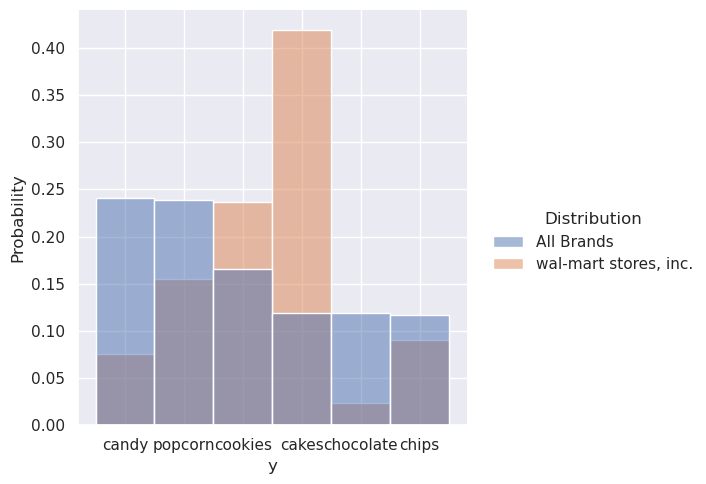

In [30]:
import seaborn as sns

most_frequesnt_brand = X_train["brand"].mode()[0]

df_all = pd.DataFrame(
    {
        "y": X_train["y"].str.split("_").apply(lambda x: x[0]),
        "Distribution": "All Brands",
    }
)
df_most_freq = pd.DataFrame(
    {
        "y": X_train[X_train["brand"] == most_frequesnt_brand]["y"]
        .str.split("_")
        .apply(lambda x: x[0]),
        "Distribution": most_frequesnt_brand,
    }
)
df_combined = pd.concat([df_all, df_most_freq])
df_combined["y"] = pd.Categorical(
    df_combined["y"], list(df_all["y"].value_counts().index)
)

sns.set_theme()
sns.displot(
    df_combined, x="y", hue="Distribution", stat="probability", common_norm=False
)

We'll get the postriot distributions using naive bayes, while treating brands as tokens (instead of separating to words).

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

sentences = X_train["brand"].str.replace(" ", "")
val_sentences = X_val["brand"].str.replace(" ", "")

# Step 1: Create the bag-of-words representation
vectorizer = CountVectorizer(ngram_range=(1, 1))
train_matrix = vectorizer.fit_transform(sentences)
val_matrix = vectorizer.transform(val_sentences)

# Step 2: Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(train_matrix, y_train)

# Step 3: Predict using the classifier
y_pred_nb = nb_classifier.predict(val_matrix)

# Step 4: Evaluation
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Classification Report:")
print(classification_report(y_val, y_pred_nb))

Accuracy: 0.6233466302750368
Classification Report:
                                      precision    recall  f1-score   support

          cakes_cupcakes_snack_cakes       0.72      0.62      0.66       561
                               candy       0.56      0.74      0.64      1128
               chips_pretzels_snacks       0.81      0.48      0.60       533
                           chocolate       0.74      0.51      0.61       556
                    cookies_biscuits       0.80      0.49      0.61       798
popcorn_peanuts_seeds_related_snacks       0.54      0.72      0.62      1187

                            accuracy                           0.62      4763
                           macro avg       0.69      0.59      0.62      4763
                        weighted avg       0.66      0.62      0.62      4763



62% Accuracy only by using the `brand`! Let's try doing the same with `description`.

The maximum snacks per brand for a certain category is not very high, and there're many unique brands. Hence, we'll drop the `brand` column.

### Description

The `description` is a very interesting column, as it contains a lot of unstructered information about the food. We'll expect to achieve much better accuracy with the Naive Bayes approach.

In [32]:
train_matrix.shape

(25400, 4479)

In [33]:
(train_matrix.sum(axis=0) > 50).sum()

101

In [34]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

sentences = X_train["description"]
val_sentences = X_val["description"]

# Step 1: Create the bag-of-words representation
vectorizer = CountVectorizer(
    stop_words="english", ngram_range=(1, 6), strip_accents="unicode"
)
train_matrix = vectorizer.fit_transform(sentences)
val_matrix = vectorizer.transform(val_sentences)

# Step 2: Train the Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(train_matrix, y_train)

# Step 3: Predict using the classifier
y_pred_nb = nb_classifier.predict(val_matrix)

# Step 4: Evaluation
print("Accuracy:", accuracy_score(y_val, y_pred_nb))
print("Classification Report:")
print(classification_report(y_val, y_pred_nb))

Accuracy: 0.9030023094688222
Classification Report:
                                      precision    recall  f1-score   support

          cakes_cupcakes_snack_cakes       0.97      0.93      0.95       561
                               candy       0.90      0.89      0.90      1128
               chips_pretzels_snacks       0.96      0.94      0.95       533
                           chocolate       0.73      0.80      0.77       556
                    cookies_biscuits       0.92      0.92      0.92       798
popcorn_peanuts_seeds_related_snacks       0.93      0.92      0.92      1187

                            accuracy                           0.90      4763
                           macro avg       0.90      0.90      0.90      4763
                        weighted avg       0.91      0.90      0.90      4763



90% accuracy is really good, considering the simplicity of the model. For each category, we'll check the most important words in the description:

In [35]:
feature_names = vectorizer.get_feature_names_out()
class_names = [name.split("_")[0] for name in nb_classifier.classes_]
num_classes = len(class_names)

for i, class_name in enumerate(class_names):
    print(f"Most important words for class '{class_name}':")
    top_features_idx = nb_classifier.feature_log_prob_[i].argsort()[::-1][:10]
    top_features = [feature_names[idx] for idx in top_features_idx]
    print(", ".join(top_features), end="\n\n")

Most important words for class 'cakes':
cake, chocolate, pie, cupcakes, mini, cakes, creme, donuts, brownie, cheesecake

Most important words for class 'candy':
candy, chocolate, fruit, sour, gummi, jelly, milk, gummy, candies, chewy

Most important words for class 'chips':
chips, potato, potato chips, tortilla, tortilla chips, kettle, corn, salt, cooked, pretzels

Most important words for class 'chocolate':
chocolate, milk, dark, milk chocolate, dark chocolate, truffles, bar, caramel, chocolates, salt

Most important words for class 'cookies':
cookies, chocolate, cookie, chip, chocolate chip, sandwich, sugar, butter, wafers, creme

Most important words for class 'popcorn':
roasted, mix, almonds, popcorn, chocolate, peanuts, salted, trail, trail mix, cashews



The intersection between the most important words for each category is very small, but not empty. For example, the word `chocolate` is important for all categories but `chips_pretzels_snacks`. The words `creme`, `milk` and `salt` are among the 10 most important words for more than a single category. We'll find out what is the extent of important words/n-grams for each category, until they become uninformative.

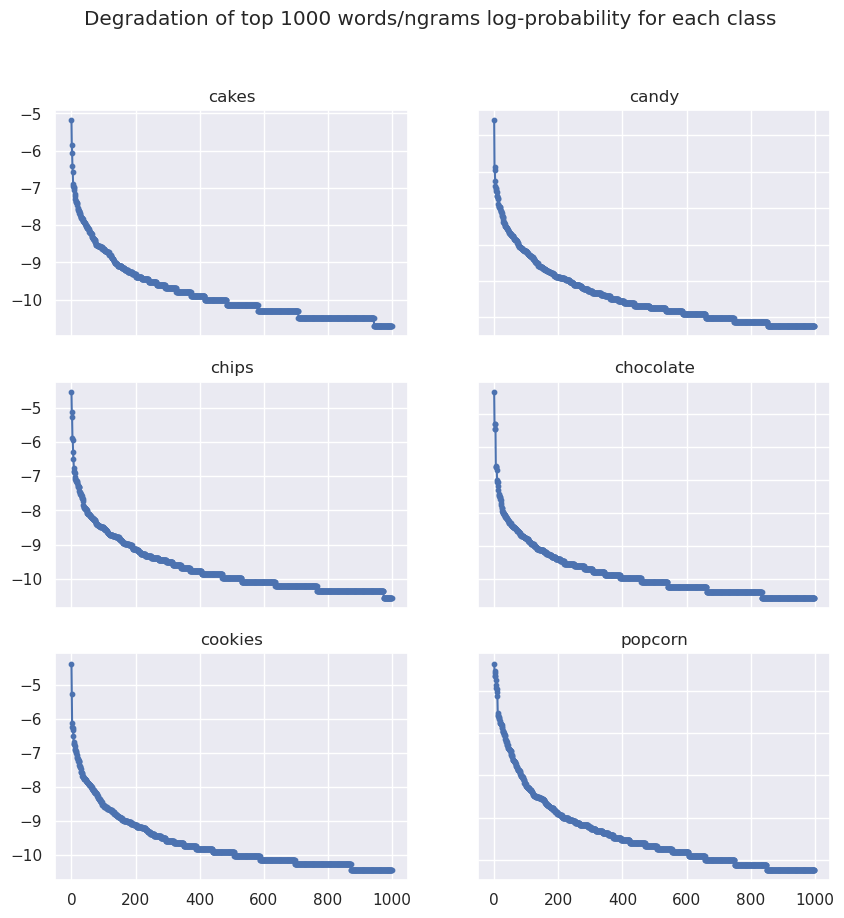

In [36]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10))
fig.suptitle("Degradation of top 1000 words/ngrams log-probability for each class")

for c in range(6):
    i, j = c // 2, c % 2
    axs[i, j].scatter(
        range(1000), np.sort(nb_classifier.feature_log_prob_[c])[-1000:][::-1], s=10
    )
    axs[i, j].plot(
        range(1000), np.sort(nb_classifier.feature_log_prob_[c])[-1000:][::-1]
    )
    axs[i, j].set_title(class_names[c])

for ax in fig.get_axes():
    ax.label_outer()

There're many different n-grams, possibly leading to big increase in the number of features. I'd like to try out a simple model first, replacing the `description` and `brand` columns, each with 6 columns - one for each category. The value of each column will be the log-probability of the feature column to associate with the category, according to the Naive Bayes model.

In [37]:
from helpers.preprocess import NaiveBayesScores

NaiveBayesScores(
    colname="brand", preprocess_func=lambda x: x.replace(" ", "")
).fit_transform(X=X_train, y=y_train)
NaiveBayesScores(
    colname="description",
    vectorizer_kwgs=dict(
        stop_words="english", ngram_range=(1, 6), strip_accents="unicode"
    ),
).fit_transform(X=X_train, y=y_train)

X_train[[f"{brand}_nb_score_chocolate" for brand in ["brand", "description"]]].head()

,brand_nb_score_chocolate,description_nb_score_chocolate
23212,-4.083942,-11.153186
22158,-2.620499,-10.779114
1703,-5.340313,-35.202871
20886,-5.111576,-1.015086
18703,-4.634516,-27.093615


In [38]:
display(X_train.iloc[:2, -6:])
np.exp(X_train.iloc[:2, -6:]).sum(axis=1)

,description_nb_score_cakes_cupcakes_snack_cakes,description_nb_score_candy,description_nb_score_chips_pretzels_snacks,description_nb_score_chocolate,description_nb_score_cookies_biscuits,description_nb_score_popcorn_peanuts_seeds_related_snacks
23212,-0.000296,-9.946544,-19.056152,-11.153186,-8.364468,-14.975742
22158,-9.864426,-8.939836,-14.902254,-10.779114,-0.000204,-15.849332


23212    1.0
22158    1.0
dtype: float64

### Serving Size Unit

In [39]:
X_train["serving_size_unit"].value_counts()

g     25392
ml        8
Name: serving_size_unit, dtype: int64

In [40]:
X_train[X_train["serving_size_unit"] == "ml"]["y"]

11626                         candy
12633                         candy
19728    cakes_cupcakes_snack_cakes
21321                         candy
25726                         candy
9445                          candy
8554                          candy
23010                         candy
Name: y, dtype: object

Not a very informative column, as >99.9% of the data is `g`. We'll drop this column.

In [41]:
from helpers.preprocess import DropColumns

DropColumns(columns=["serving_size_unit"]).fit_transform(X=X_train)

,idx,ingredients,serving_size,household_serving_fulltext,y,protein__(g),total_lipid_(fat)__(g),carbohydrate_by_difference__(g),starch__(g),alcohol_ethyl__(g),...,brand_nb_score_chips_pretzels_snacks,brand_nb_score_chocolate,brand_nb_score_cookies_biscuits,brand_nb_score_popcorn_peanuts_seeds_related_snacks,description_nb_score_cakes_cupcakes_snack_cakes,description_nb_score_candy,description_nb_score_chips_pretzels_snacks,description_nb_score_chocolate,description_nb_score_cookies_biscuits,description_nb_score_popcorn_peanuts_seeds_related_snacks
23212,25784,sugar bleached_wheat_flour soybean_oil,28.0,1 onz,cakes_cupcakes_snack_cakes,3.57,21.43,60.71,0.0,0,...,-2.536376,-4.083942,-1.782971,-0.769932,-2.955858e-04,-9.946544,-1.905615e+01,-11.153186,-8.364468e+00,-14.975742
22158,24607,filling wheat_flour baking_powder,30.0,4 pieces,cookies_biscuits,3.33,30.00,66.67,0.0,0,...,-2.655216,-2.620499,-0.524252,-2.361643,-9.864426e+00,-8.939836,-1.490225e+01,-10.779114,-2.043734e-04,-15.849332
1703,1898,enriched_wheat_flour water sugar,54.0,4 holes,cakes_cupcakes_snack_cakes,5.56,22.22,48.15,0.0,0,...,-2.045440,-5.340313,-2.346195,-0.622098,-5.684342e-14,-38.317800,-3.704711e+01,-35.202871,-3.078935e+01,-34.671889
20886,23191,sugar_wheat_flour_nonfat_milk_cocoa_butter_cho...,42.0,1 four-piece bar,candy,7.14,26.19,64.29,0.0,0,...,-5.331526,-5.111576,-5.439135,-3.481568,-1.893499e+01,-0.475797,-2.609830e+01,-1.015086,-4.120400e+00,-14.198123
18703,20739,sugar enriched_bleached_flour vegitable_shorening,67.0,2 cakes/1 pkg,cakes_cupcakes_snack_cakes,2.99,13.43,65.67,0.0,0,...,-4.669234,-4.634516,-2.874742,-4.375660,-3.836931e-12,-28.661906,-3.243408e+01,-27.093615,-2.707072e+01,-32.675462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,33105,sugar enriched_wheat_flour_bleached vegetable_oil,85.0,3 onz,cakes_cupcakes_snack_cakes,3.53,21.18,55.29,0.0,0,...,-3.260487,-3.631234,-1.689139,-0.887471,-2.452065e-04,-9.989179,-2.056641e+01,-10.494364,-8.687072e+00,-12.773131
5390,6019,sugar enriched_bleached_wheat_flour margarine,38.0,1 cookie,cookies_biscuits,2.63,13.16,65.79,0.0,0,...,-2.386696,-4.125424,-3.350340,-0.916953,-2.756156e+01,-34.492868,-3.967875e+01,-37.524420,-1.080025e-12,-37.188134
860,960,corn line_and_corn_oil,39.0,1.4 onz,chips_pretzels_snacks,5.13,23.08,66.67,0.0,0,...,-1.099541,-2.163436,-2.013100,-1.904580,-2.307783e+01,-22.299619,-1.962732e-09,-22.797426,-2.048519e+01,-22.045293
15795,17524,sunflower_seeds almonds date_sugar,28.0,0.25 cup,cookies_biscuits,14.29,25.00,25.00,0.0,0,...,-2.532322,-2.491713,-1.797598,-1.035861,-4.621251e+00,-4.138648,-3.092892e+00,-4.000533,-5.547572e-01,-1.089671


### Serving Size

First, we'll take a look at the distribution of the serving size per category:

[Text(0.5, 0, 'Category'), Text(0, 0.5, 'Log Serving size')]

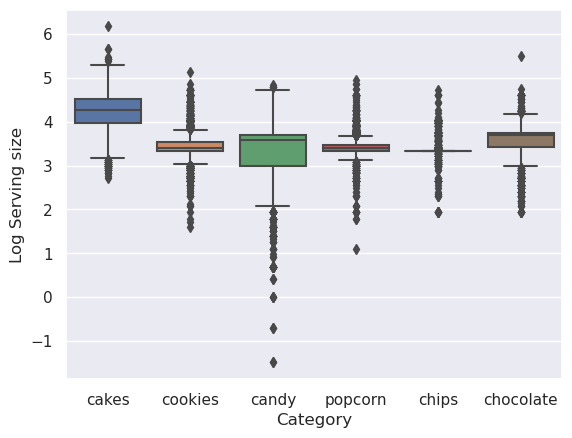

In [42]:
import seaborn as sns
import numpy as np

ax = sns.boxplot(
    x=X_train["y"].apply(lambda x: x.split("_")[0]), y=np.log(X_train["serving_size"])
)
ax.set(xlabel="Category", ylabel="Log Serving size")
# sns.set_axis_labels("Category", "Serving size [g]")

Can't really tell how helpful this column is, as the distribution is somewhat similar for some categories. It may be useful to know that when the serving size is low, the food is probably a candy, and there might be more patterns like that. This column is 'cheap' for our model, as it is a numeric column with no missing values. We'll keep this column for now, after applying log transformation.

In [43]:
from helpers.preprocess import LogTransformation

LogTransformation(columns=["serving_size"]).fit_transform(X=X_train)

,idx,ingredients,serving_size,household_serving_fulltext,y,protein__(g),total_lipid_(fat)__(g),carbohydrate_by_difference__(g),starch__(g),alcohol_ethyl__(g),...,brand_nb_score_chips_pretzels_snacks,brand_nb_score_chocolate,brand_nb_score_cookies_biscuits,brand_nb_score_popcorn_peanuts_seeds_related_snacks,description_nb_score_cakes_cupcakes_snack_cakes,description_nb_score_candy,description_nb_score_chips_pretzels_snacks,description_nb_score_chocolate,description_nb_score_cookies_biscuits,description_nb_score_popcorn_peanuts_seeds_related_snacks
23212,25784,sugar bleached_wheat_flour soybean_oil,3.332205,1 onz,cakes_cupcakes_snack_cakes,3.57,21.43,60.71,0.0,0,...,-2.536376,-4.083942,-1.782971,-0.769932,-2.955858e-04,-9.946544,-1.905615e+01,-11.153186,-8.364468e+00,-14.975742
22158,24607,filling wheat_flour baking_powder,3.401197,4 pieces,cookies_biscuits,3.33,30.00,66.67,0.0,0,...,-2.655216,-2.620499,-0.524252,-2.361643,-9.864426e+00,-8.939836,-1.490225e+01,-10.779114,-2.043734e-04,-15.849332
1703,1898,enriched_wheat_flour water sugar,3.988984,4 holes,cakes_cupcakes_snack_cakes,5.56,22.22,48.15,0.0,0,...,-2.045440,-5.340313,-2.346195,-0.622098,-5.684342e-14,-38.317800,-3.704711e+01,-35.202871,-3.078935e+01,-34.671889
20886,23191,sugar_wheat_flour_nonfat_milk_cocoa_butter_cho...,3.737670,1 four-piece bar,candy,7.14,26.19,64.29,0.0,0,...,-5.331526,-5.111576,-5.439135,-3.481568,-1.893499e+01,-0.475797,-2.609830e+01,-1.015086,-4.120400e+00,-14.198123
18703,20739,sugar enriched_bleached_flour vegitable_shorening,4.204693,2 cakes/1 pkg,cakes_cupcakes_snack_cakes,2.99,13.43,65.67,0.0,0,...,-4.669234,-4.634516,-2.874742,-4.375660,-3.836931e-12,-28.661906,-3.243408e+01,-27.093615,-2.707072e+01,-32.675462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29802,33105,sugar enriched_wheat_flour_bleached vegetable_oil,4.442651,3 onz,cakes_cupcakes_snack_cakes,3.53,21.18,55.29,0.0,0,...,-3.260487,-3.631234,-1.689139,-0.887471,-2.452065e-04,-9.989179,-2.056641e+01,-10.494364,-8.687072e+00,-12.773131
5390,6019,sugar enriched_bleached_wheat_flour margarine,3.637586,1 cookie,cookies_biscuits,2.63,13.16,65.79,0.0,0,...,-2.386696,-4.125424,-3.350340,-0.916953,-2.756156e+01,-34.492868,-3.967875e+01,-37.524420,-1.080025e-12,-37.188134
860,960,corn line_and_corn_oil,3.663562,1.4 onz,chips_pretzels_snacks,5.13,23.08,66.67,0.0,0,...,-1.099541,-2.163436,-2.013100,-1.904580,-2.307783e+01,-22.299619,-1.962732e-09,-22.797426,-2.048519e+01,-22.045293
15795,17524,sunflower_seeds almonds date_sugar,3.332205,0.25 cup,cookies_biscuits,14.29,25.00,25.00,0.0,0,...,-2.532322,-2.491713,-1.797598,-1.035861,-4.621251e+00,-4.138648,-3.092892e+00,-4.000533,-5.547572e-01,-1.089671


## Images Dataset

Let's use ResNet18 as fixed feature extractor, and see how well can we predict the category by applying a linear classifier on top of the features extracted from the images.

Based on https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [44]:
from torchvision import models
from resnet import get_datasets
import torch
from tqdm import tqdm
import pandas as pd

model_ft = models.resnet18(weights="IMAGENET1K_V1")
model_ft.fc = torch.nn.Linear(model_ft.fc.in_features, 6)
food_test = pd.read_csv("data/food_test.csv")
food_test["category"] = 'chocolate'
labels_test = food_test["category"]

# datasets = get_datasets(X_train, y_train, X_val, y_val)
datasets = get_datasets(food_test, labels_test, food_test, labels_test)

# if False:
model_ft.load_state_dict(
    torch.load("checkpoints/resnet18/best_model_params_only_images.pt", map_location=torch.device('cpu'))
)
model_ft.eval()

with torch.no_grad():
    for phase, ds in datasets.items():
        if phase == "train":
            continue
        features, labels = [], []
        loop = tqdm(range(len(ds)))
        for i in loop:
            _, image, label = ds[i]
            resnet18_features = model_ft(image.unsqueeze(0)).squeeze().numpy()

            features.append(resnet18_features)
            labels.append(label)
            
        rs18_df = pd.DataFrame(features)
        # rs18_df["y"] = labels
        rs18_df.to_csv(f"data/resnet18_food_test_features_fine_tuned.csv")

ModuleNotFoundError: No module named 'torchvision'

In [ ]:
from helpers.preprocess import (
    FillNA,
    MergeWithFoodNutrients,
    CleanAndListifyIngredients,
    NaiveBayesScores,
    LogTransformation,
    DropColumns,
    StemDescription,
)
from imblearn.pipeline import Pipeline

steps = [
    FillNA(),
    MergeWithFoodNutrients(nutrient_min_freq=2),
    CleanAndListifyIngredients(),
    StemDescription(),
    NaiveBayesScores(colname="brand", preprocess_func=lambda x: x.replace(" ", ""),
            vectorizer_kwgs=dict(
            stop_words="english", ngram_range=(1, 6), strip_accents="unicode", min_df=20
        ),
        mode="count",
        use_tfidf=False,
    ),
    NaiveBayesScores(
        colname="description",
        vectorizer_kwgs=dict(
            stop_words="english", ngram_range=(1, 6), strip_accents="unicode", min_df=50
        ),
        mode="count",
        use_tfidf=False,
    ),
    NaiveBayesScores(
        colname="ingredients",
        vectorizer_kwgs=dict(
            stop_words="english", ngram_range=(1, 6), strip_accents="unicode", min_df=50, max_df=0.6
        ),
        mode="count",
        use_tfidf=False,
    ),
    NaiveBayesScores(
        colname="household_serving_fulltext",
        vectorizer_kwgs=dict(stop_words="english", ngram_range=(1, 6), strip_accents="unicode", min_df=50),
        mode="count",
        use_tfidf=False,
    ),
    LogTransformation(columns=["serving_size"]),
    DropColumns(columns=["serving_size_unit"]),
]


pipe = Pipeline([(f"{i}", step) for i, step in enumerate(steps)])

In [45]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Define the number of classes (6 in your case)
num_classes = 6

# Split the dataset into training and testing sets
train_data = pd.read_csv("data/resnet18_train_features.csv")
val_data = pd.read_csv("data/resnet18_val_features.csv")

X_train_logistic = train_data.drop(columns=["y"])
X_val_logistic = val_data.drop(columns=["y"])
labels_train = train_data["y"]
labels_val = val_data["y"]

# Create the logistic regression model
model = LogisticRegression(multi_class="multinomial", solver="lbfgs")

# Train the model on the training data
model.fit(X_train_logistic, labels_train)

# Make predictions on the test data
labels_pred = model.predict(X_val_logistic)

# Calculate the accuracy of the model
accuracy = accuracy_score(labels_val, labels_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5145916439218979


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Recall that 24% of the images describe candy. We got a bad accuracy by using a frozen ResNet18 and applying a logistic regression over the output features. Let's see if PCA would help us to get better accuracy, as there're 1000 features for each image, and 6 target classes.

In [46]:
from sklearn.decomposition import PCA

num_components = 100
pca = PCA(n_components=num_components)

pca.fit(X_train_logistic)

X_train_pca = pca.transform(X_train_logistic)
X_val_pca = pca.transform(X_val_logistic)

model = LogisticRegression(multi_class="multinomial", solver="lbfgs")

model.fit(X_train_pca, labels_train)

labels_pred = model.predict(X_val_pca)

accuracy = accuracy_score(labels_val, labels_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5284484568549234


/opt/conda/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Doesn't seem like PCA really helped us to get better accuracy. Later, we'll try to fine-tune the ResNet18 model, and see if we can get better results.